In [15]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/kfu-hw-1-classification-2024/test.tsv
/kaggle/input/kfu-hw-1-classification-2024/train.tsv


In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
import spacy
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from textblob import TextBlob
from nltk import download
import pymorphy2
from transformers import pipeline

In [17]:
test_data = pd.read_csv('/kaggle/input/kfu-hw-1-classification-2024/test.tsv')
train_data = pd.read_csv('/kaggle/input/kfu-hw-1-classification-2024/train.tsv')

train_data.head()

,id,tweet,class
0,760402871867367424,"Настало время для ингаляторов. Дружок, Сальбут...",0
1,1035908416869462016,15) На прошлой зимней олимпиаде большинство лы...,1
2,1089839736427032577,Не соглашусь с заменой ЗОК на метопролол в так...,0
3,779671488748224513,"@di2m1 мезим Смекта Если отравление, то лоперамид",0
4,738309299756240897,Уберите микроволновки и имодиум Действуют соу...,0


**EDA**

In [18]:
train_data['class'].value_counts()

class
0    8683
1     832
Name: count, dtype: int64

In [19]:
print(train_data.isnull().sum())
print(test_data.isnull().sum())

id       0
tweet    0
class    0
dtype: int64
id       0
tweet    0
dtype: int64


In [7]:
print(train_data['tweet'].duplicated().sum())

1


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


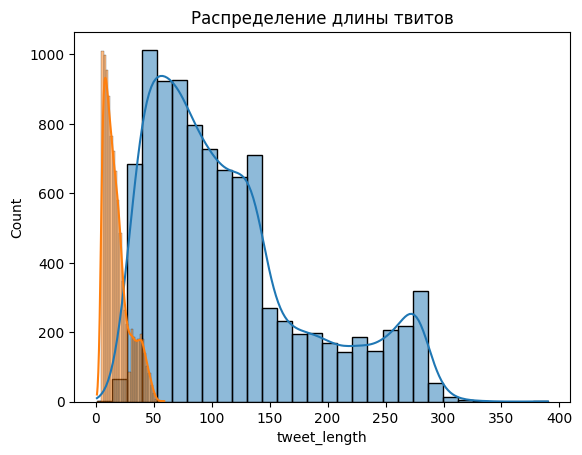

In [20]:
train_data['tweet_length'] = train_data['tweet'].apply(len)
train_data['word_count'] = train_data['tweet'].apply(lambda x: len(x.split()))


sns.histplot(train_data['tweet_length'], kde=True, bins=30)
sns.histplot(train_data['word_count'], kde=True, bins=30)
plt.title("Распределение длины твитов")
plt.show()

Топ-20 слов: [('и', 5216), ('не', 3438), ('в', 3326), ('на', 2356), ('я', 2119), ('что', 1940), ('с', 1826), ('-', 1407), ('а', 1177), ('это', 1064), ('от', 1057), ('как', 1055), ('у', 945), ('мне', 901), ('меня', 885), ('но', 877), ('по', 822), ('Я', 612), ('так', 583), ('за', 567)]


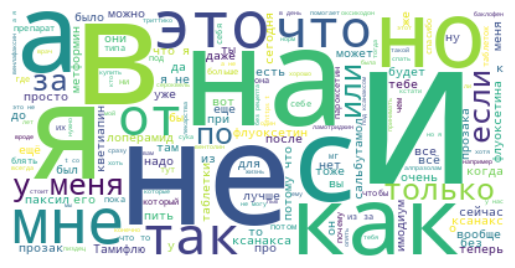

In [21]:
def get_top_n_words(corpus, n=None):
    words = ' '.join(corpus).split()
    return Counter(words).most_common(n)

all_tweets = train_data['tweet']
top_words = get_top_n_words(all_tweets, n=20)
print("Топ-20 слов:", top_words)

wordcloud = WordCloud(background_color='white').generate(' '.join(all_tweets))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [25]:
!pip install spacy
!python -m spacy download ru_core_news_sm

2025-01-21 10:30:30.491339: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-21 10:30:30.509733: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-21 10:30:30.515231: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
DEPRECATION: https://github.com/explosion/spacy-models/releases/download/ru_core_news_sm-3.1.0/ru_core_news_sm-3.1.0-py3-none-any.whl#egg=ru_core_news_sm==3.1.0 contains an egg fragment with a non-PEP 508 name pip 25.0 will enforce this behaviour change. A possible replacement is to use the req @ url syntax, and remove the egg fragment. Discussion can be found at

**Feature Engineering**

In [30]:
nlp = spacy.load('ru_core_news_sm')

def pos_analysis(text):
    doc = nlp(text)
    return [token.pos_ for token in doc]


train_data['pos_tags'] = train_data['tweet'].apply(pos_analysis)
train_data.head(5)

/usr/local/lib/python3.10/dist-packages/spacy/util.py:910: UserWarning: [W095] Model 'ru_core_news_sm' (3.1.0) was trained with spaCy v3.1.0 and may not be 100% compatible with the current version (3.7.5). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


KeyboardInterrupt: 

In [ ]:
train_data.head(5)

,id,tweet,class,tweet_length,word_count,pos_tags
0,760402871867367424,"Настало время для ингаляторов. Дружок, Сальбут...",0,59,8,"[PROPN, VERB, PROPN, PROPN, PUNCT, PROPN, PUNC..."
1,1035908416869462016,15) На прошлой зимней олимпиаде большинство лы...,1,276,44,"[X, PUNCT, PROPN, NOUN, PROPN, PROPN, PROPN, P..."
2,1089839736427032577,Не соглашусь с заменой ЗОК на метопролол в так...,0,178,31,"[PROPN, PROPN, PROPN, PROPN, PROPN, PROPN, PRO..."
3,779671488748224513,"@di2m1 мезим Смекта Если отравление, то лоперамид",0,49,7,"[PROPN, ADP, PROPN, PROPN, NOUN, PUNCT, PROPN,..."
4,738309299756240897,Уберите микроволновки и имодиум Действуют соу...,0,52,6,"[PROPN, PROPN, ADJ, ADJ, SPACE, PROPN, NOUN]"


In [34]:
# Text normalization

download('stopwords')
download('punkt')

stop_words = set(stopwords.words('russian'))
morph = pymorphy2.MorphAnalyzer()

def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    tokens = [morph.parse(token)[0].normal_form for token in tokens if token.isalnum() and token not in stop_words]
    return ' '.join(tokens)

train_data['cleaned_tweet'] = train_data['tweet'].apply(preprocess_text)

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [35]:
train_data.head()

,id,tweet,class,tweet_length,word_count,pos_tags,cleaned_tweet
0,760402871867367424,"Настало время для ингаляторов. Дружок, Сальбут...",0,59,8,"[VERB, NOUN, ADP, NOUN, PUNCT, PROPN, PUNCT, P...",настать время ингалятор дружок сальбутамол
1,1035908416869462016,15) На прошлой зимней олимпиаде большинство лы...,1,276,44,"[NUM, PUNCT, ADP, ADJ, ADJ, NOUN, NOUN, NOUN, ...",15 прошлый зимний олимпиада большинство лыжник...
2,1089839736427032577,Не соглашусь с заменой ЗОК на метопролол в так...,0,178,31,"[PART, VERB, ADP, NOUN, PROPN, ADP, NOUN, ADP,...",согласиться замена зок метопролоть такой вид п...
3,779671488748224513,"@di2m1 мезим Смекта Если отравление, то лоперамид",0,49,7,"[X, NOUN, PROPN, SCONJ, NOUN, PUNCT, SCONJ, NOUN]",di2m1 мезим смект отравление лоперамид
4,738309299756240897,Уберите микроволновки и имодиум Действуют соу...,0,52,6,"[VERB, NOUN, CCONJ, NOUN, SPACE, VERB, NOUN]",убрать микроволновка имодиум действовать соулмэйт


In [ ]:
# Sentiment analysis

classifier = pipeline("sentiment-analysis", model="blanchefort/rubert-base-cased-sentiment")

def analyze_sentiment(text):
    result = classifier(text)[0]  
    return result['label'], result['score']  

train_data[['sentiment_label', 'sentiment_score']] = train_data['tweet'].apply(
    lambda x: pd.Series(analyze_sentiment(x))
)

print(train_data)

config.json:   0%|          | 0.00/943 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/711M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/499 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.40M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cpu
